### PCA elbow selection across sessions (reproducibility figure)

**Inputs**
- `*_68localized_50epochs.npy` files in `/lustre/majlepy2/myproject/50_epochs_tc3d/`  
  Each file shape: `(nodes, samples, epochs)`.

**Procedure**
1. Load each array, reshape to 2D `(epochs×samples, nodes)`, and vertically stack all sessions.
2. Standardize features (per-node z-score) and fit PCA (full spectrum).
3. Detect elbow with `KneeLocator`; if no knee, fall back to the first index with ≥75% cumulative variance.
4. Re-fit PCA with the selected dimensionality.
5. Save figures documenting the decision:
   - `pca_cumulative_variance.png`
   - `pca_individual_variance.png`

**Notes**
- PCA (full SVD) is deterministic; results are reproducible given the same inputs.
- This cell *reports the dimensionality* and *saves figures*; it does not persist the reduced data.
- Edit the `base` and `figdir` paths if your environment differs.


Included: sub-001_ses-01_68localized_50epochs.npy: (50, 130, 68) -> (6500, 68)
Included: sub-007_ses-01_68localized_50epochs.npy: (50, 130, 68) -> (6500, 68)
Included: sub-008_ses-01_68localized_50epochs.npy: (50, 130, 68) -> (6500, 68)
Included: sub-008_ses-02_68localized_50epochs.npy: (50, 130, 68) -> (6500, 68)
Included: sub-009_ses-01_68localized_50epochs.npy: (50, 130, 68) -> (6500, 68)
Included: sub-011_ses-01_68localized_50epochs.npy: (50, 130, 68) -> (6500, 68)
Included: sub-011_ses-02_68localized_50epochs.npy: (50, 130, 68) -> (6500, 68)
Included: sub-012_ses-01_68localized_50epochs.npy: (50, 130, 68) -> (6500, 68)
Included: sub-012_ses-02_68localized_50epochs.npy: (50, 130, 68) -> (6500, 68)
Included: sub-014_ses-01_68localized_50epochs.npy: (50, 130, 68) -> (6500, 68)
Included: sub-014_ses-02_68localized_50epochs.npy: (50, 130, 68) -> (6500, 68)
Included: sub-015_ses-01_68localized_50epochs.npy: (50, 130, 68) -> (6500, 68)
Included: sub-015_ses-02_68localized_50epochs.npy: (

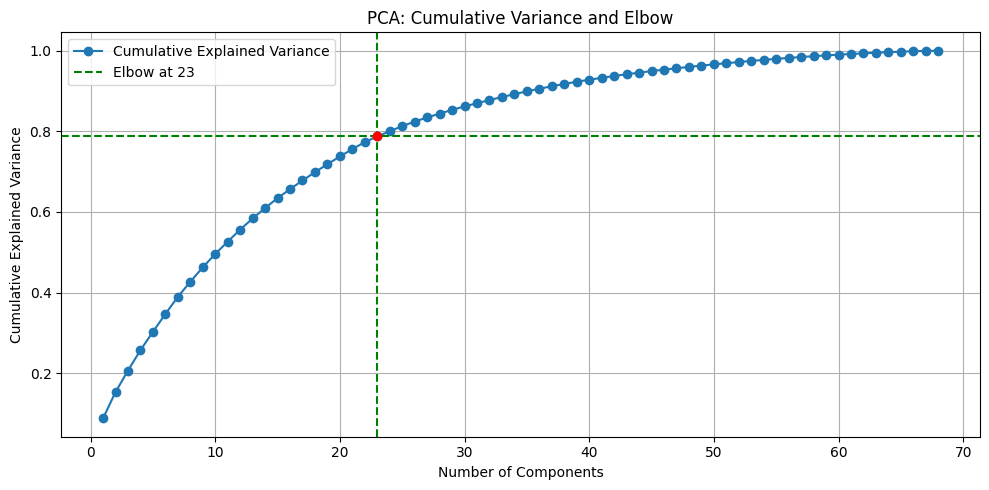

Saved individual variance figure to /home/majlepy2/myproject/pca_individual_variance.png


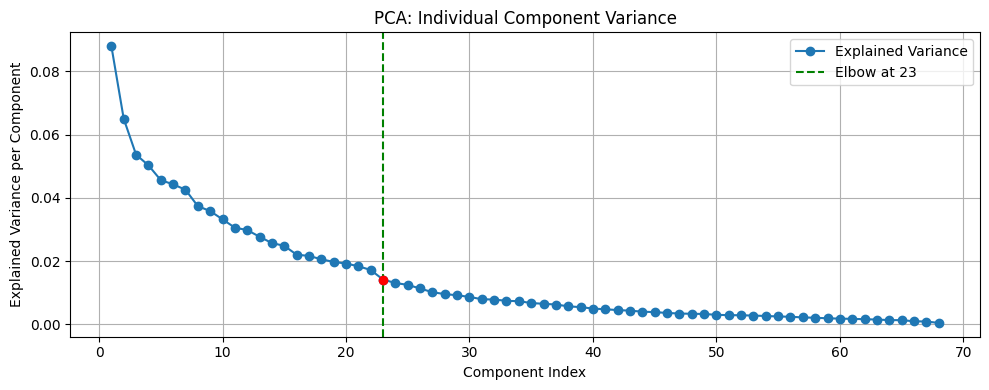

In [2]:
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from kneed import KneeLocator

# === Purpose ===============================================================
# Select a PCA dimensionality via an "elbow" (knee) on cumulative explained
# variance, using all sessions concatenated. Saves two figures that document
# the elbow selection. This cell is deterministic given the input files
# (scikit-learn's PCA with full SVD is deterministic).
#
# Input files:
#   /lustre/majlepy2/myproject/50_epochs_tc3d/*_68localized_50epochs.npy
#   Each .npy has shape (nodes, samples, epochs)
# Output figures:
#   /home/majlepy2/myproject/pca_cumulative_variance.png
#   /home/majlepy2/myproject/pca_individual_variance.png
#
# Notes:
# - We standardize features (z-score) before PCA.
# - If KneeLocator fails to find a knee, we fall back to the first index
#   where cumulative explained variance >= 75%.
# - This cell *does not* write the reduced data; it only reports/plots the elbow.
# ===========================================================================

# === Paths (edit `base` if your data live elsewhere) =======================
base = Path("/lustre/majlepy2/myproject/50_epochs_tc3d")
paths = sorted(base.glob("*_68localized_50epochs.npy"))  # 3D arrays: (nodes, samples, epochs)

# === Output directory for figures ==========================================
figdir = Path("/home/majlepy2/myproject")
figdir.mkdir(parents=True, exist_ok=True)

# === Load and stack all sessions ===========================================
# We reshape each array from (nodes, samples, epochs) to a 2D matrix with rows
# = time points across all epochs and columns = nodes: (epochs * samples, nodes).
arrays = []
for p in paths:
    arr = np.load(p)                    # (nodes, samples, epochs)
    arr = arr.transpose(2, 1, 0)        # -> (epochs, samples, nodes)
    arr_flat = arr.reshape(-1, arr.shape[2])  # -> (epochs*samples, nodes)
    arrays.append(arr_flat)
    print(f"Included: {p.name}: {arr.shape} -> {arr_flat.shape}")

# Concatenate all sessions along rows (time points)
data = np.vstack(arrays)
print("Data shape before PCA:", data.shape)

# === Standardize features (columns) ========================================
# PCA assumes centered/normalized features; StandardScaler makes each node zero-mean, unit-variance.
scaler = StandardScaler()
X_z = scaler.fit_transform(data)

# === PCA (full) for elbow detection ========================================
# Fit PCA with all components to obtain the full cumulative explained-variance curve.
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_z)
explained_var = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained_var)

# === Elbow detection (Kneedle; fallback to 75% variance) ===================
x = np.arange(1, len(cum_explained) + 1)
knee = KneeLocator(x, cum_explained, curve='concave', direction='increasing')
elbow_point = knee.knee if knee.knee else np.argmax(cum_explained >= 0.75) + 1
print(f"Elbow detected at {elbow_point} components (~{cum_explained[elbow_point - 1]:.2%} variance explained)")

# === Re-fit PCA using chosen dimensionality =================================
pca = PCA(n_components=elbow_point)
X_pca = pca.fit_transform(X_z)
print(f"PCA output shape using elbow: {X_pca.shape}")

# === Figure 1: Cumulative explained variance + elbow =======================
plt.figure(figsize=(10, 5))
plt.plot(x, cum_explained, marker='o', label='Cumulative Explained Variance')
plt.axvline(elbow_point, color='green', linestyle='--', label=f'Elbow at {elbow_point}')
plt.axhline(cum_explained[elbow_point - 1], color='green', linestyle='--')
plt.scatter(elbow_point, cum_explained[elbow_point - 1], color='red', zorder=5)  # highlight point
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Cumulative Variance and Elbow")
plt.legend()
plt.grid(True)
plt.tight_layout()

cum_fig = figdir / "pca_cumulative_variance.png"
plt.savefig(cum_fig, dpi=300, bbox_inches="tight")
print(f"Saved cumulative variance figure to {cum_fig}")
plt.show()

# === Figure 2: Per-component explained variance ============================
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, len(explained_var) + 1), explained_var, marker='o', label="Explained Variance")
plt.axvline(elbow_point, color='green', linestyle='--', label=f'Elbow at {elbow_point}')
plt.scatter(elbow_point, explained_var[elbow_point - 1], color='red', zorder=5)  # highlight point
plt.xlabel("Component Index")
plt.ylabel("Explained Variance per Component")
plt.title("PCA: Individual Component Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()

indiv_fig = figdir / "pca_individual_variance.png"
plt.savefig(indiv_fig, dpi=300, bbox_inches="tight")
print(f"Saved individual variance figure to {indiv_fig}")
plt.show()
